In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

This could be one of your way before transitioning to X-Ray images. 
Suppose we knew a very good training model, and the authors publish the model.
Unfortunately, the model was trained with respect to different dataset as ours.
However, we feel that the datasets share a degree of similarity (though it is very abstract), we can perform transfer learning as previously demonstrated.

In this noteboox, we will emulate it by using ImageNet and a custom dataset.
We use a daset from Kaggle (https://www.kaggle.com/positivepc/object-detection).
The objective is to detect whether an image is an electric bus or and electric car. Pretty simple, right?

# Import and Subroutine

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms, models # --> new
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 

import requests
from PIL import Image


In [3]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy().transpose(1,2,0)
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.22))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy

In [4]:
class FinetunedModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # load pretrained model
        model = models.alexnet(pretrained=True)
        
        self.features = model.features
        self.avgpool = model.avgpool
        self.classifier = model.classifier
        
        # freeze the feature learning
        for param in self.features.parameters():
              param.requires_grad = False
        
        # change the number of output classes of the last layer
        # this is useless line as it the number of output classes is already set to be 10
        self.classifier[-1] = nn.Linear(
            in_features=self.classifier[-1].in_features,
            out_features=2)
        
        # follow https://pytorch.org/hub/pytorch_vision_alexnet/
        tf_resize = transforms.Resize((256,256)) 
        tf_centercrop = transforms.CenterCrop(224)
        tf_totensor = transforms.ToTensor() 
        tf_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        self.tf_compose = transforms.Compose([
            tf_resize,
            tf_centercrop,
            tf_totensor,
            tf_normalize,
        ])
        
    def forward(self,x):
#         import pdb; pdb.set_trace()
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        
        outputs = self.forward(inputs)
#         import pdb; pdb.set_trace()
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            dataset_full = datasets.ImageFolder(root='./dataset/training/', transform=self.tf_compose)
            
            # split
            SIZE_TRAIN_DATA = int(len(dataset_full)*0.75)
            SIZE_VAL_DATA = len(dataset_full)-SIZE_TRAIN_DATA
            self.dataset_train, self.dataset_val = random_split(dataset_full, [SIZE_TRAIN_DATA,SIZE_VAL_DATA])
            
        if stage == 'test' or stage is None:
            self.dataset_test = datasets.ImageFolder(root='./dataset/test/', transform=self.tf_compose)
            
#         import pdb; pdb.set_trace()
            
    def train_dataloader(self): 
        return DataLoader(self.dataset_train, batch_size=50, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=50, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=50, num_workers=2)

In [5]:
pl.seed_everything(1412) # --> for consistency, change the number with your favorite number :D

model = FinetunedModel()

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
try:
    trainer = pl.Trainer(gpus=1,max_epochs=5,default_root_dir='./custom_logs')
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=5,default_root_dir='./custom_logs')

    
trainer.fit(model)

Global seed set to 1412
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/ardimas/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: custom_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 2.5 M 
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 54.5 M
-------------------------------------------------
54.5 M    Trainable params
2.5 M     Non-trainable params
57.0 M    Total params
228.048   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from to

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [6]:
trainer.test()

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at custom_logs/lightning_logs/version_0/checkpoints/epoch=4-step=115.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at custom_logs/lightning_logs/version_0/checkpoints/epoch=4-step=115.ckpt
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` ar

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.981675386428833
        test_loss          0.049194302409887314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.049194302409887314, 'test_acc': 0.981675386428833}]

# Visualization

Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

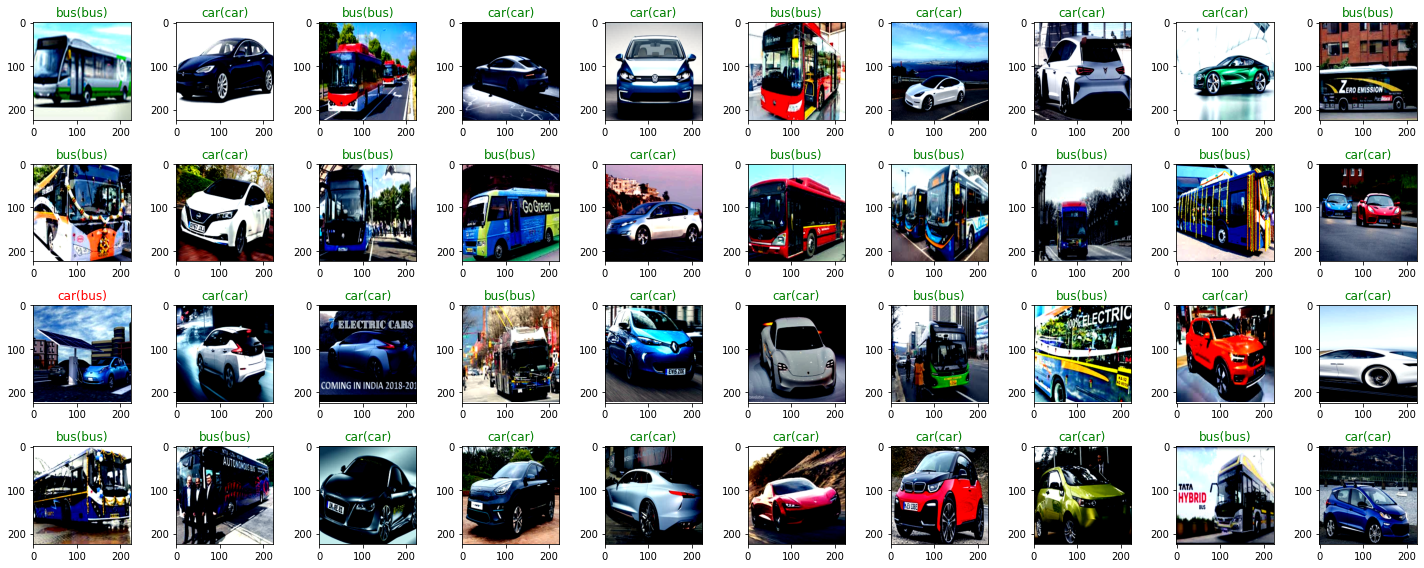

In [7]:
dataset_classes = ['bus','car']

def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(dataset_classes[label])
    
loader = DataLoader(model.dataset_test, batch_size=1, shuffle=True)

plt.figure(figsize=(20, 8))
for idx,(img,label) in enumerate(loader):
    plt.subplot(4,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = dataset_classes[label]
    title_pred = dataset_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 40-1:
        break
        
plt.tight_layout()